# Poiseuille flow

## Radial distribution function


### Libraries imported

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import nglview

### RDF(r) using Plotly

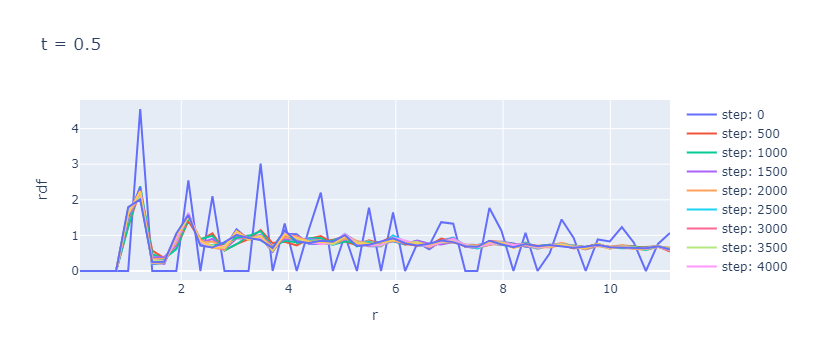

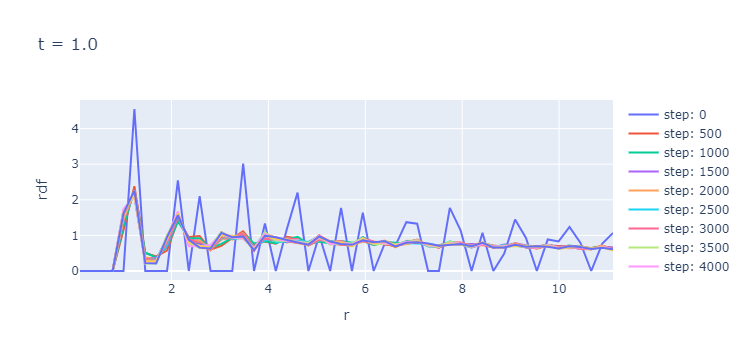

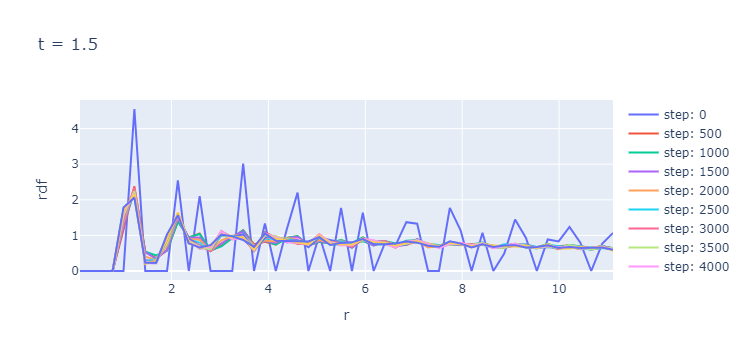

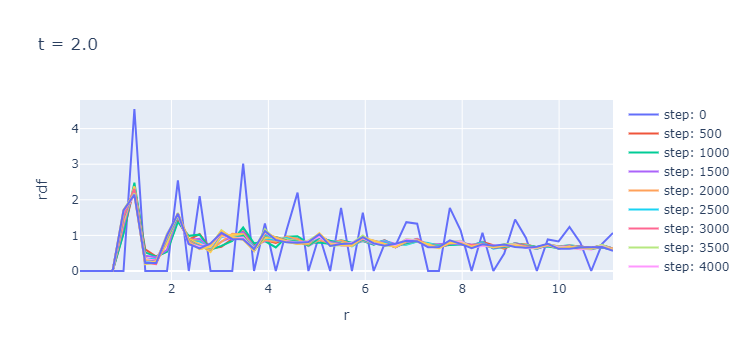

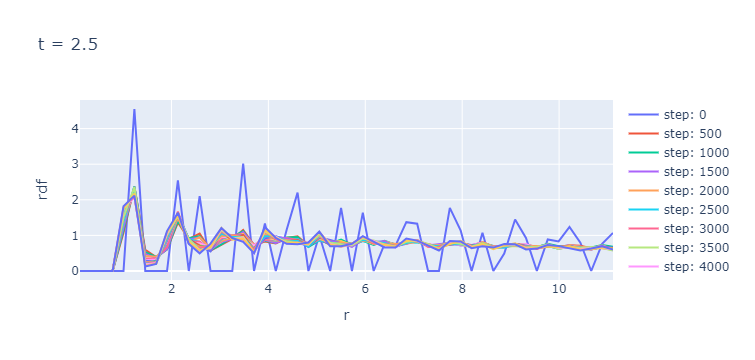

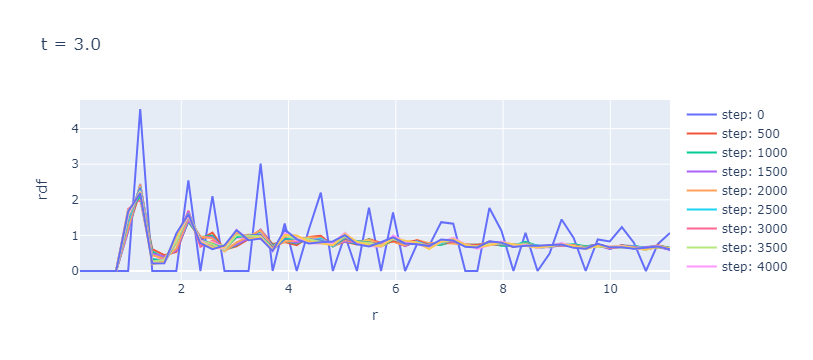

In [12]:
Temp=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
for temp in Temp:
    f=open('./scripts/rdf/tmp_{}.rdf'.format(temp))
    Nlines=0
    rdf_dict={}
    for line in f.readlines():
        if (line[0]=='#'):
            continue
        lineS=line.split()
        if (len(lineS) == 2):
            Nlines=int(lineS[1])
            step=int(lineS[0])
            rdf_dict[step]={
                'r': [],
                'rdf': []
            }
            continue
        if not (len(lineS) == 4):
            print ("Error: not 4 columns")
            break
        if (Nlines<0):
            print ("Error: Nlines < 0")
            break

        rdf_dict[step]['r'].append(float(lineS[1]))
        rdf_dict[step]['rdf'].append(float(lineS[2]))
        Nlines -= 1
    fig = go.Figure()
    for step in rdf_dict:
        fig.add_trace(go.Scatter(x=rdf_dict[step]['r'], y=rdf_dict[step]['rdf'], name="step: {:d}".format(step)))
    fig.update_layout(title="t = "+str(temp), yaxis=dict(title="rdf"), xaxis=dict(title="r"))
    fig.show()

### Visualization using Nglview

In [15]:
from ase.io import read
data = read("./scripts/dump.flow", index=":")
from ase.visualize import view 
view(data, viewer="ngl")

In [16]:
nglview.show_asetraj(data, gui = True)

NGLWidget(max_frame=20)

### Visualization using Ovito

In [ ]:
from ovito.io import import_file

pipeline = import_file("/home/common/studtscm15/project/flow.pois/scripts/dump.flow")

pipeline.add_to_scene()

import ovito.modifiers as md

def mod_color_radius(frame, data):
    radius_property = data.particles_.create_property("Radius")
    color_property = data.particles_.create_property("Color")
    type_property = data.particles_.create_property("Particle Type")
    for i in range(len(radius_property)):
        if type_property.array[i] == 3:
            color_property.marray[i] = (112/250, 112/250, 112/250)
        if type_property.array[i] == 2:
            color_property.marray[i] = (66/250, 170/250, 255/250)
        if type_property.array[i] == 1:
            color_property.marray[i] = (250/250, 96/250, 127/250)
        radius_property.marray[i] = 1.0

pipeline.modifiers.append(md.PythonScriptModifier(function = mod_color_radius))

data = pipeline.compute()

import math
import ovito.vis as vis
import numpy as np

wall_x = data.cell[0][0]
wall_y = data.cell[1][1]
wall_z = data.cell[2][2]

vp = vis.Viewport()
vp.type = vis.Viewport.Type.Perspective

def get_pos_dir(frame):
    global wall_x, wall_y
    center = np.array([wall_x/2, wall_y/2, wall_z/2])
    radius = wall_x/2 + wall_y/2*3**0.5
    phi = frame/20*2*np.pi
    direction = np.array([0,0,1])
    return tuple(center + direction*radius), tuple(-direction)

pos, direction = get_pos_dir(0)
vp.camera_pos = pos
vp.camera_dir = direction
vp.fov = math.radians(60.0)

def render_view(args):
    pos, direction = get_pos_dir(args.frame)
    args.viewport.camera_pos = pos
    args.viewport.camera_dir = direction
    vp.fov = math.radians(60.0)

vp.overlays.append(vis.PythonViewportOverlay(function = render_view))

vp.render_anim(size=(400,400), filename = "pois.mp4", renderer=vis.TachyonRenderer(), range = (0, 20))



In [14]:
from IPython.display import Video

Video("pois.mp4")